In [1]:
# !add-apt-repository ppa:ubuntugis/ubuntugis-unstable -y
# !apt-get update
# !apt-get install python-numpy gdal-bin libgdal-dev python3-rtree

# !pip install rasterio
# !pip install geopandas
# !pip install descartes
# !pip install solaris
# !pip install rio-tiler
# !pip install pystac

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

In [4]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import solaris as sol
from pathlib import Path
import rasterio
from rasterio.windows import Window
import geopandas as gpd
from pystac import (Catalog, CatalogType, Item, Asset, LabelItem, Collection)
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from rio_tiler import main as rt_main
import skimage
from tqdm import tqdm
import os
# os.environ["CURL_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"

# # We have to add this wrkaround for stackio:
# # (https://pystac.readthedocs.io/en/latest/concepts.html#using-stac-io)
# from urllib.parse import urlparse
# import requests
# from pystac import STAC_IO
# def my_read_method(uri):
#     parsed = urlparse(uri)
#     if parsed.scheme.startswith('http'):
#         return requests.get(uri).text
#     else:
#         return STAC_IO.default_read_text_method(uri)
# STAC_IO.read_text_method = my_read_method

In [5]:
from src_em.tiff_slicer import geojson_to_squares
from src_em.tiff_slicer import cleanup_invalid_geoms

In [6]:
TIFF_PATH = "/home/zakirov/datasets/opencities/train_tier_1/acc/d41d81/d41d81.tif"
GEOJSON_PATH = "/home/zakirov/datasets/opencities/train_tier_1/acc/d41d81-labels/d41d81.geojson"

In [7]:
label_df = gpd.read_file(GEOJSON_PATH)
label_df = label_df[label_df['geometry'].isna() != True] # remove empty rows

In [8]:
# label_df.plot(figsize=(10,10));

In [9]:
ZOOM_LEVEL=19
TILE_SIZE=512

In [10]:
# !cat $GEOJSON_PATH | supermercado burn {ZOOM_LEVEL} | mercantile shapes | fio collect > trn_aoi_z{ZOOM_LEVEL}tiles.geojson

In [11]:
tiles_gdf = geojson_to_squares(GEOJSON_PATH, ZOOM_LEVEL, val_percent=0.15)

In [12]:
tiles_gdf.head(1)

,id,title,geometry,xyz,dataset
0,"(261867, 253985, 19)","XYZ tile (261867, 253985, 19)","POLYGON ((-0.19020 5.59275, -0.19020 5.59343, ...","[261867, 253985, 19]",val


In [15]:
tiles_gdf.dataset.value_counts()

train    341
val       66
Name: dataset, dtype: int64

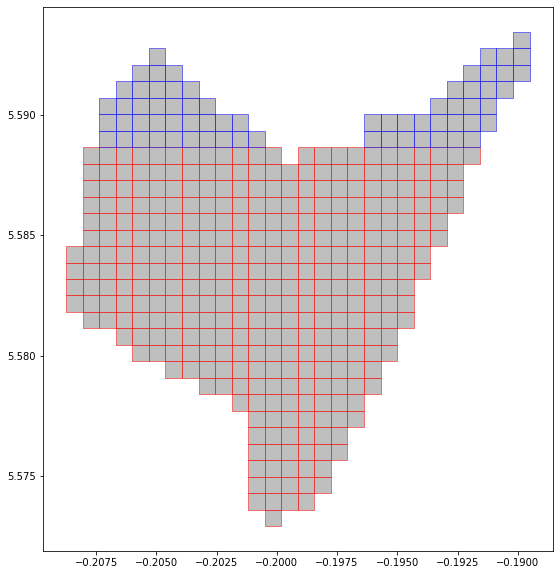

In [68]:
fig, ax = plt.subplots(figsize=(10, 10))
tiles_gdf[tiles_gdf.train].plot(ax=ax, figsize=(10,10), color='grey', alpha=0.5, edgecolor='red');
tiles_gdf[tiles_gdf.train == False].plot(ax=ax, figsize=(10,10), color='grey', alpha=0.5, edgecolor='blue');

In [69]:
from rio_tiler import main as rt_main

# import mercantile
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

In [ ]:
tqdm()

In [70]:
all_polys = label_df.geometry
# all_polys.head(3)

In [71]:
all_polys = cleanup_invalid_geoms(all_polys)

In [72]:
idx = np.random.randint(0, len(tiles_gdf))
# idx=412
tiles_gdf.iloc[idx]['xyz']
tile, mask = rt_main.tile(TIFF_PATH, *tiles_gdf.iloc[idx]['xyz'], tilesize=TILE_SIZE)
# plt.figure(figsize=(7, 7))
# plt.imshow(np.moveaxis(tile,0,2));

In [73]:
# get the same tile polygon as our tile image above
tile_poly = tiles_gdf.iloc[idx]['geometry']
# print(tile_poly.bounds)
# tile_poly

In [74]:
# get affine transformation matrix for this tile using rasterio.transform.from_bounds: https://rasterio.readthedocs.io/en/stable/api/rasterio.transform.html#rasterio.transform.from_bounds
tfm = from_bounds(*tile_poly.bounds, TILE_SIZE, TILE_SIZE) 
# tfm

In [75]:
# crop znz001 geometries to what overlaps our tile polygon bounds
cropped_polys = [poly for poly in all_polys if poly.intersects(tile_poly)]
cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs=4326)
# cropped_polys_gdf.plot()

In [76]:
# burn a footprint/boundary/contact 3-channel mask with solaris: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_masks_tutorial.html
# we're only using it 
fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
                                         channels=['footprint', 'boundary', 'contact'],
                                         affine_obj=tfm, shape=(TILE_SIZE,TILE_SIZE),
                                         boundary_width=7, boundary_type='inner', contact_spacing=5, meters=True)

In [17]:
# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
# ax1.imshow(np.moveaxis(tile,0,2))
# ax2.imshow(fbc_mask)

In [93]:
# fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10, 5))
# ax1.imshow(fbc_mask[:,:,0])
# ax2.imshow(fbc_mask[:,:,1])
# ax3.imshow(fbc_mask[:,:,2])